# COCO DDPM

In [1]:
# |default_exp coco_ddpm

In [27]:
# |export
import json
import multiprocessing
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms.v2 as T
from datasets import Dataset
from PIL import Image
from tqdm import tqdm

from slowai.coco import black_and_white, preprocess_super_rez, to_img
from slowai.cos_revisited import noisify, ᾱ
from slowai.learner import DataLoaders
from slowai.tinyimagenet_a import denorm, fill, norm
from slowai.utils import show_images

In [30]:
try:
    with open("data/coco_color_fps.json") as f:
        color_fps = json.load(f)["fps_color"]
except FileNotFoundError:
    fps = [str(fi) for fi in Path("data/train2017").glob("**/*.jpg")]
    color_fps = []
    with multiprocessing.Pool() as p:
        iter_ = zip(p.imap(black_and_white, fps), fps)
        for b_w, fp in tqdm(iter_, total=len(fps)):
            if not b_w:
                color_fps.append(fp)
    with open("data/coco_color_fps.json", "wt") as f:
        color_fps = json.dump({"fps_color": fps_color}, f)

In [32]:
# |export
def coco_2017_trn(fps=None, n=None, remove_bw=True):
    if fps is None:
        fps = Path(fp).glob("**/*.jpg")
    if n:
        fps = fps[:n]
    ds = Dataset.from_dict({"image_fp": [str(fp) for fp in fps]})

    def open_images(examples):
        imgs = []
        for img_fp in examples["image_fp"]:
            img = Image.open(img_fp)
            imgs.append(img)
        return {"image": imgs}

    ds = ds.map(open_images, batched=True)
    ds = ds.train_test_split(test_size=0.1)
    return ds

In [33]:
%%time
ds = coco_2017_trn(fps_color)

Map:   0%|          | 0/113265 [00:00<?, ? examples/s]

FileNotFoundError: [Errno 2] No such file or directory: 'data/train2017/000000532106.jpg'

In [20]:
# |export
def crop_to_box(img: "Image"):
    width, height = img.size
    if width > height:
        new_width = height
        new_height = height
        left = (width - new_width) // 2
        top = 0
        right = left + new_width
        bottom = new_height
    else:
        new_width = width
        new_height = width
        left = 0
        top = (height - new_height) // 2
        right = new_width
        bottom = top + new_height
    img_cropped = img.crop((left, top, right, bottom))
    return img_cropped

In [21]:
# |export
trn_preprocess_super_rez = [
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=(0.35, 1.65), hue=(-0.05, 0.05)),
    T.RandomAffine(scale=(1.0, 1.2), degrees=(0, 20), fill=fill),
    crop_to_box,
    T.Resize((150, 150)),
    T.RandomCrop((128, 128)),
    T.PILToTensor(),
]
tst_preprocess_super_rez = [
    crop_to_box,
    T.Resize((150, 150)),
    T.CenterCrop((128, 128)),
    T.PILToTensor(),
]
blur = T.GaussianBlur((5, 9), (0.1, 5.0))
postprocess_ = T.Compose([T.ConvertImageDtype(torch.float), norm])

In [24]:
# |export
def preprocess_ddpm(examples, pipe, extra_blur=False):
    pre = T.Compose(pipe)
    imgs = []
    for img in examples["image"]:
        img = img.convert("RGB")
        img_hr = pre(img)
        # Note that this resizing discards details but retains the image
        # dimensions, which makes it slightly easier to design the network
        img_lr = TF.resize(img_hr, (64, 64), antialias=True)
        if extra_blur:
            img_lr = blur(img_lr)
        img_lr = TF.resize(img_lr, (128, 128), antialias=False)
        img_hr, img_lr = map(postprocess_, (img_hr, img_lr))
        imgs.append((img_hr, img_lr))
    imgs_hr, imgs_lr = map(torch.stack, zip(*imgs))
    return {"image_high_rez": imgs_hr, "image_low_rez": imgs_lr}

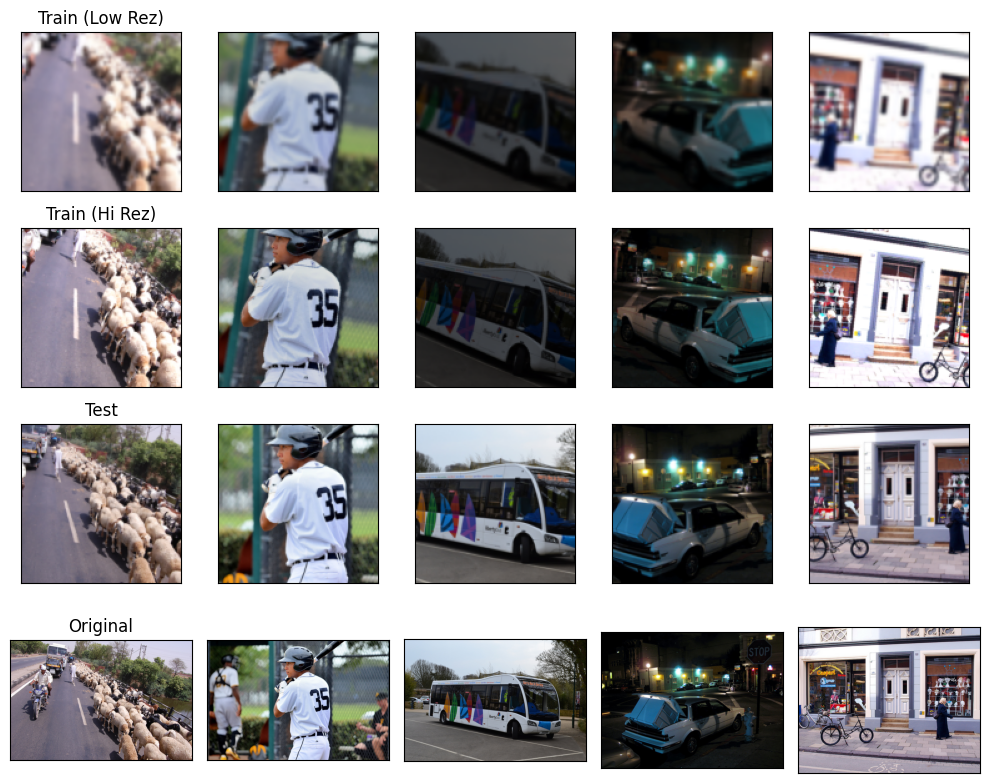

In [23]:
rows = ds["train"][:6]
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
trn = preprocess_ddpm(rows, pipe=trn_preprocess_super_rez)
tst = preprocess_ddpm(rows, pipe=tst_preprocess_super_rez)
for im_trn_hi, im_trn_lo, im_test, im_org, ax_col in zip(
    trn["image_high_rez"],
    trn["image_low_rez"],
    tst["image_high_rez"],
    rows["image"],
    axes.T,
):
    for ax, im in zip(ax_col, (im_trn_lo, im_trn_hi, im_test)):
        ax.imshow(denorm(im).permute(1, 2, 0))
    ax_col[3].imshow(im_org)
axes[0, 0].set(title="Train (Low Rez)")
axes[1, 0].set(title="Train (Hi Rez)")
axes[2, 0].set(title="Test")
axes[3, 0].set(title="Original")
fig.tight_layout()

In [55]:
# |export
def get_coco_dataset(
    fac,
    trn,
    tst,
    fp="data/train2017",
    bs=512,
    n=None,
    columns=["image_low_rez", "image_high_rez"],
):
    fps = Path(fp).glob("**/*.jpg")
    dsd = coco_2017_trn(fps, n=n)
    dsd["train"].set_transform(partial(fac, pipe=trn))
    dsd["train"] = dsd["train"].shuffle()
    dsd["test"] = (
        dsd["test"]
        .map(
            partial(fac, pipe=tst),
            batched=True,
            # Unused, no need to collate and waste time/compute
            remove_columns=["image"],
        )
        .with_format("torch")
    )

    return DataLoaders.from_dsd(dsd, bs=bs).listify(columns=columns)

In [56]:
# |export
get_coco_dataset_super_rez = partial(
    get_coco_dataset,
    preprocess_super_rez,
    trn_preprocess_super_rez,
    tst_preprocess_super_rez,
)

In [57]:
%%time
dls = get_coco_dataset_super_rez(n=100)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

CPU times: user 320 ms, sys: 35.5 ms, total: 355 ms
Wall time: 173 ms


We also want to do colorization

In [58]:
# |export
grayscale = T.Grayscale(num_output_channels=3)

In [69]:
# |export
def preprocess_colorization(examples, pipe):
    pre = T.Compose(pipe)
    imgs = []
    for img in examples["image"]:
        img_color = pre(img.convert("RGB"))
        img_bw = grayscale(img_color)
        img_color, img_bw = map(postprocess_, (img_color, img_bw))
        imgs.append((img_color, img_bw))
    imgs_color, imgs_bw = map(torch.stack, zip(*imgs))
    return {"color": imgs_color, "bw": imgs_bw}

In [60]:
# |export
get_coco_dataset_colorization = partial(
    get_coco_dataset,
    preprocess_colorization,
    trn_preprocess_super_rez,
    tst_preprocess_super_rez,
    columns=["bw", "color"],
)

In [61]:
%%time
dls = get_coco_dataset_colorization(n=100)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

CPU times: user 319 ms, sys: 25 ms, total: 344 ms
Wall time: 156 ms


In [62]:
xb, yb = dls.peek()

In [63]:
denorm(xb).max()

tensor(0.9961)

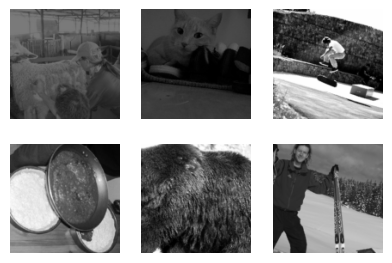

In [64]:
show_images(denorm(xb[:6, ...]), imsize=(1.6))

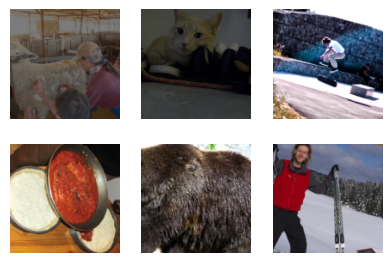

In [65]:
show_images(denorm(yb[:6, ...]), imsize=(1.6))

In [1]:
#| hide
import nbdev

nbdev.nbdev_export()